In [1]:
import time
import importlib

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras import backend as K
from Modules import utils, tf_utils, plot_utils, models
from Modules.tf_utils import mae_cor, correlate

2023-06-23 12:52:06.098969: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
importlib.reload(utils)
importlib.reload(tf_utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [29]:
importlib.reload(models)
model = models.inception_dna_v2(101)
print(model.summary())
del model

Model: "inception_dna_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 101, 4)]     0                                            
__________________________________________________________________________________________________
first_conv (Conv1D)             (None, 101, 64)      1600        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_0 (MaxPooling1D)       (None, 51, 64)       0           first_conv[0][0]                 
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 51, 48)       9264        max_pool_0[0][0]                 
___________________________________________________________________________________

2023-06-02 17:55:20.762024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-06-02 17:55:20.839871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 17:55:20.840293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-06-02 17:55:20.840367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 17:55:20.840544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

In [7]:
model = models.mnase_Maxime(2001)
print(model.summary())
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1999, 32)          416       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 999, 32)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 999, 32)           128       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 990, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 495, 32)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 495, 32)           128       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 476, 32)           2

In [3]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz')) as f:
    x_train = f['chr02']
    x_valid = f['chr14']
    x_test = f['chr16']
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    y_train = f['chr02']
    y_valid = f['chr14']
    y_test = f['chr16']
x_train.shape

(844051, 4)

In [6]:
def valid_windows(one_hot_chr, labels, winsize):
    N_mask = (np.sum(one_hot_chr, axis=1) == 0)
    N_window_mask = np.asarray(
        np.convolve(N_mask, np.ones(winsize), mode='same'),
        dtype=int)
    valid_window_mask = (N_window_mask == 0) & (labels != 0).ravel()
    indexes = np.arange(len(one_hot_chr))[valid_window_mask]
    indexes = indexes[
        (indexes >= winsize // 2)
        & (indexes < len(one_hot_chr) - (winsize // 2))]
    return indexes

In [7]:
x_eff = valid_windows(x_valid, y_valid, 2001)
len(x_eff)

764064

In [17]:
gen_x = tf_utils.WindowGenerator(x_valid, y_valid, 2001, 1024, 2**22)
gen_x.max_data

238115

In [15]:
2**20

1048576

In [4]:
def predict(model, one_hot_chr, winsize=2001):
    X = utils.chunk_chr(one_hot_chr, 2001)[1]
    pred = np.zeros(len(one_hot_chr))
    pred[winsize//2:-(winsize//2)] = model.predict(X)[:, 0]
    return pred

In [20]:
preds = {}

In [6]:
data = 'MMusculus'
with np.load(Path(data_dir, data, 'genome', 'mm10.npz')) as f:
    x_test = f['chr3']

In [7]:
model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm2', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test1 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test1_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
# print(model.layers[0].input_shape[1])#.input_shape[0][1])
del model

model = tf.keras.models.load_model(Path(data_dir, 'MMusculus', 'Trainedmodels', 'model_mnase_mm3', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test2 = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001)
pred_test2_rev = tf_utils.predict(model, x_test[10_000_000:10_100_000], 2001, reverse=True)
del model

2023-04-24 14:47:34.656518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-24 14:47:34.677081: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-04-24 14:47:44.813776: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 249.88MiB (rounded to 262012928)requested by op sequential/conv1d/conv1d
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-24 14:47:44.813878: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-04-24 14:47:44.813909: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 104, Chunks in use: 104. 26.0KiB allocated for chunks. 26.0KiB in use in bin. 5.2Ki

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,32,1,1999] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv1d/conv1d (defined at home/alex/mnhn-internship_DeepCNN_ChIP-seq/Modules/tf_utils.py:647) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_7241]

Function call stack:
predict_function


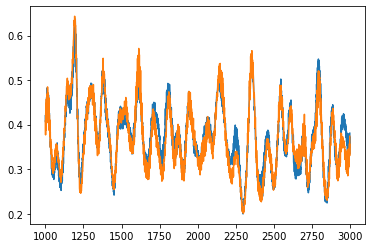

In [74]:
start = 1_000
stop = start + 2_000
plt.plot(np.arange(start, stop), pred_test1[start:stop], label='for_on_for')
plt.plot(np.arange(start, stop), pred_test1_rev[start:stop], label='for_on_rev')
# plt.plot(np.arange(start, stop), pred_test2[start:stop], label='rev_on_for')
# plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='rev_on_rev')
plt.show()
plt.close()

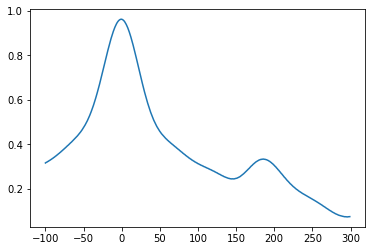

In [75]:
slide_corr = []
offsets = np.arange(-100, 300, 1)
for i in offsets:
    if i == 0:
        corr = pearsonr(pred_test1, pred_test1_rev)[0]
    elif i > 0:
        corr = pearsonr(pred_test1[i:], pred_test1_rev[:-i])[0]
    else:
        corr = pearsonr(pred_test1_rev[-i:], pred_test1[:i])[0]
    slide_corr.append(corr)
plt.plot(offsets, slide_corr)
plt.show()
plt.close()

In [71]:
def sliding_correlation(X, Y, offsets):
    slide_corr = []
    for i in offsets:
        if i == 0:
            corr = pearsonr(X, Y)[0]
        elif i > 0:
            corr = pearsonr(X[i:], Y[:-i])[0]
        else:
            corr = pearsonr(Y[-i:], X[:i])[0]
        slide_corr.append(corr)
    return slide_corr

def fast_sliding_correlation(X, Y, offsets):
    assert len(X) == len(Y)
    min_offset = np.min(offsets)
    max_offset = np.max(offsets)
    max_len = len(X) - max_offset + min_offset
    offsets -= min_offset
    windows = offsets.reshape(-1, 1) + np.arange(max_len).reshape(1, -1)
    X_slides = X[windows]
    slide_corrs = utils.lineWiseCorrcoef(X_slides, Y[-min_offset:-min_offset+max_len])
    return slide_corrs

(400, 99601)


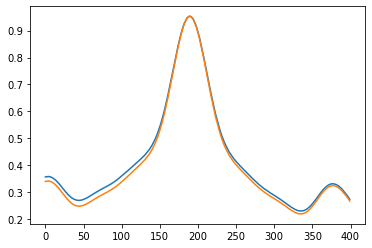

In [68]:
offsets = np.arange(-100, 300)
slide_corrs = sliding_correlation(pred_test1, pred_test1_rev, offsets)
fast_slide_corrs = fast_sliding_correlation(pred_test1, pred_test1_rev, offsets)
plt.plot(offsets, slide_corrs)
plt.plot(offsets, fast_slide_corrs)
plt.show()
plt.close()

In [69]:
%%timeit
sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

202 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
fast_sliding_correlation(pred_test1, pred_test1_rev, np.arange(-100, 300))

221 ms ± 362 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# preds['model_mnase_11'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
# preds['model_mnase_12'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
preds['model_mnase_13'] = [pred_test, pred_valid, pred_train, pred_test_rev, pred_valid_rev, pred_train_rev]
for pred_model in preds.keys():
    print(pred_model)

model_mnase_11
model_mnase_13


In [19]:
test_corrs = np.corrcoef([y_test, pred_test, pred_test_rev])
valid_corrs = np.corrcoef([y_valid, pred_valid, pred_valid_rev])
train_corrs = np.corrcoef([y_train, pred_train, pred_train_rev])
test_corrs, valid_corrs, train_corrs

(array([[1.        , 0.57081365, 0.5822789 ],
        [0.57081365, 1.        , 0.66006644],
        [0.5822789 , 0.66006644, 1.        ]]),
 array([[1.        , 0.56816693, 0.56442126],
        [0.56816693, 1.        , 0.62536211],
        [0.56442126, 0.62536211, 1.        ]]),
 array([[1.        , 0.8913237 , 0.57227383],
        [0.8913237 , 1.        , 0.62596317],
        [0.57227383, 0.62596317, 1.        ]]))

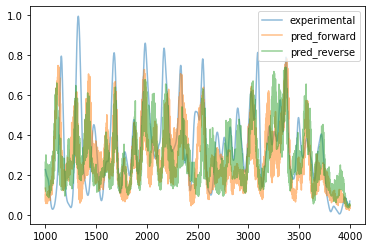

In [25]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), y_test[start:stop], label='experimental', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test[start:stop], label='pred_forward', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_reverse', alpha=0.5)
plt.legend()
plt.show()
plt.close()

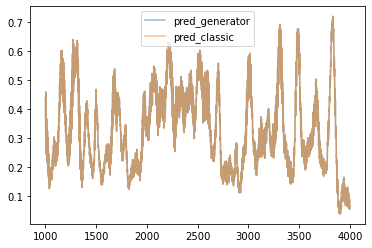

In [36]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_generator', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test2_rev[start:stop], label='pred_classic', alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [36]:
def merge_chroms(chr_ids, file):
    annot = []
    with np.load(file) as f:
        for chr_id in chr_ids:
            annot.append(f[chr_id])
            shape, dtype = f[chr_id].shape, f[chr_id].dtype
            annot.append(np.zeros((1,)+shape[1:], dtype=dtype))
    return np.concatenate(annot)

In [43]:
a = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz'))
a.shape

(9409640, 4)

In [ ]:
b = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz'))
b.shape

In [3]:
def correlate(y_true, y_pred):
    """
		Calculate the correlation between the predictions and the labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = correlate)
		>>> load_model('file', custom_objects = {'correlate : correlate})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    return sigma_XY/(sigma_X*sigma_Y + K.epsilon())

def mae_cor(y_true, y_pred):
    """
	   Calculate the mean absolute error minus the correlation between
        predictions and  labels.

		:Example:

		>>> model.compile(optimizer = 'adam', losses = mae_cor)
		>>> load_model('file', custom_objects = {'mae_cor : mae_cor})
	"""
    X = y_true - K.mean(y_true)
    Y = y_pred - K.mean(y_pred)
    
    sigma_XY = K.sum(X*Y)
    sigma_X = K.sqrt(K.sum(X*X))
    sigma_Y = K.sqrt(K.sum(Y*Y))
    
    cor = sigma_XY/(sigma_X*sigma_Y + K.epsilon())
    mae = K.mean(K.abs(y_true - y_pred))
    
    return 1 + mae - cor

def rolling_window(array, window=(0,), asteps=None, wsteps=None, axes=None, toend=True):  
    """ 
        Take a numpy array and return a view of this array after applying a rolling window.

        This takes a numpy and cut it in several pieces with the size, the stride and the 
        axes asked as needed. You may want to use it in order to create a set of sequences
        from an array.

        :param array: The array we want to cut
        :param window: The length of the window
        :param asteps: The stride between two window applied
        :param wsteps: The stride whitin the window
        :param axes: The axe on which to apply the rolling window
        :param toend: Weither or not to finish the cut
        :type array: numpy array
        :type window: int or tuple
        :type asteps: int or tuple
        :type wsteps: int or tuple
        :type axes: int
        :type toend: boolean
        :return: The view of the array
        :rtype: numpy array

        :Example:

        >>> a = numpy.array([0,1,2,3,4,5])
        >>> rolling_window(a, window = 2, asteps = 2, wsteps = None)
        array([[0,1],
               [2,3],
               [4,5]])
        >>> rolling_window(a, window = 2, asteps = None, wsteps = 2)
        array([[0,2],
               [1,3],
               [2,4]
               [3,5]])
        >>> rolling_window(a, window = 5, asteps = 2, wsteps = None)
        array([[0,1,2,3,4]])

        .. warning:: Be carreful about the combination of window, wsteps and asteps that may raise 
                     ValueError. This function forces the window to be of the asked size and thus 
                     may stop the application of the window before the end.
    """        

    array = np.asarray(array)
    orig_shape = np.asarray(array.shape)
    window = np.atleast_1d(window).astype(int) # maybe crude to cast to int...

    if axes is not None:
        axes = np.atleast_1d(axes)
        w = np.zeros(array.ndim, dtype=int)
        for axis, size in zip(axes, window):
            w[axis] = size
        window = w

    # Check if window is legal:
    if window.ndim > 1:
        raise ValueError("`window` must be one-dimensional.")
    if np.any(window < 0):
        raise ValueError("All elements of `window` must be larger than 1.")
    if len(array.shape) < len(window):
        raise ValueError("`window` length must be less or equal `array` dimension.") 

    _asteps = np.ones_like(orig_shape)
    if asteps is not None:
        asteps = np.atleast_1d(asteps)
        if asteps.ndim != 1:
            raise ValueError("`asteps` must be either a scalar or one dimensional.")
        if len(asteps) > array.ndim:
            raise ValueError("`asteps` cannot be longer then the `array` dimension.")
        # does not enforce alignment, so that steps can be same as window too.
        _asteps[-len(asteps):] = asteps
        
        if np.any(asteps < 1):
             raise ValueError("All elements of `asteps` must be larger then 1.")
    asteps = _asteps

    _wsteps = np.ones_like(window)
    if wsteps is not None:
        wsteps = np.atleast_1d(wsteps)
        if wsteps.shape != window.shape:
            raise ValueError("`wsteps` must have the same shape as `window`.")
        if np.any(wsteps < 0):
             raise ValueError("All elements of `wsteps` must be larger then 0.")

        _wsteps[:] = wsteps
        _wsteps[window == 0] = 1 # make sure that steps are 1 for non-existing dims.
    wsteps = _wsteps

    # Check that the window would not be larger than the original:
    if np.any(orig_shape[-len(window):] < window * wsteps):
        raise ValueError("`window` * `wsteps` larger then `array` in at least one dimension.")

    new_shape = orig_shape # just renaming...

    # For calculating the new shape 0s must act like 1s:
    _window = window.copy()
    _window[_window==0] = 1

    new_shape[-len(window):] += wsteps - _window * wsteps
    new_shape = (new_shape + asteps - 1) // asteps
    # make sure the new_shape is at least 1 in any \"old\" dimension (ie. steps
    # is (too) large, but we do not care.
    new_shape[new_shape < 1] = 1
    shape = new_shape

    strides = np.asarray(array.strides)
    strides *= asteps
    new_strides = array.strides[-len(window):] * wsteps
    
    # The full new shape and strides:
    if toend:
        new_shape = np.concatenate((shape, window))
        new_strides = np.concatenate((strides, new_strides))
    else:
        _ = np.zeros_like(shape)
        _[-len(window):] = window
        _window = _.copy()
        _[-len(window):] = new_strides
        _new_strides = _
        
        new_shape = np.zeros(len(shape)*2, dtype=int)
        new_strides = np.zeros(len(shape)*2, dtypenucleotid=int)
        
        new_shape[::2] = shape
        new_strides[::2] = strides
        new_shape[1::2] = _window
        new_strides[1::2] = _new_strides
    
    new_strides = new_strides[new_shape != 0]
    new_shape = new_shape[new_shape != 0]
    
    return np.lib.stride_tricks.as_strided(array, shape=new_shape, strides=new_strides)

# Adaptation from Etienne's predict functions for each annotation
def predict(one_hot_chr, model, annotation_type, last_window=True):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        # X = rolling_window(one_hot_chr, window=(WINDOW, 4))[:, 0, :, None,  :]
        X = utils.sliding_window_view(one_hot_chr, window=(WINDOW, 4)).reshape(-1, WINDOW, 1, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X)[:, 0]
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        X = rolling_window(one_hot_chr, window=(WINDOW, 4), asteps=(WINDOW, 4))[:, 0, :, :]
        pred = np.zeros((len(one_hot_chr),))
        y = model.predict(X)
        y = np.repeat(y.ravel(), 128)
        pred[:len(y)] = y
        if last_window:
            X = one_hot_chr[-WINDOW:].reshape((1, WINDOW, 4))
            y = model.predict(X)
            y = np.repeat(y.ravel(), 128)
            leftover = len(pred) % WINDOW
            if leftover != 0:
                pred[-leftover:] = y[-leftover:]
    return pred

# Adaptation to make full predictions
def full_predict(one_hot_chr, model, annotation_type, last_window=True):
    if annotation_type == 'nucleosome':
        WINDOW = 2001
        side_arr = np.zeros_like(one_hot_chr, shape=(WINDOW // 2, 4))
        one_hot_chr = np.vstack([side_arr, one_hot_chr, side_arr])
        X = utils.sliding_window_view(one_hot_chr, window=(WINDOW, 4)).reshape(-1, WINDOW, 1, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        pred[WINDOW//2:-(WINDOW//2)] = model.predict(X).squeeze()
    else:
        if annotation_type == 'cohesine':
            WINDOW = 32768
        elif annotation_type == 'pol':
            WINDOW = 2048
        else:
            raise ValueError('annotation_type must be "nucleosome", "cohesine" or "pol"')
        if WINDOW > len(one_hot_chr):
            raise ValueError('sequence too small')
        head_interval = 128
        X = utils.strided_sliding_window_view(one_hot_chr, (WINDOW, 4), stride=WINDOW, sliding_len=head_interval).reshape(-1, WINDOW, 4)
        pred = np.zeros(len(one_hot_chr), dtype='float32')
        y = model.predict(X).squeeze()
        n_heads = y.shape[-1]
        y = np.transpose(y.reshape(-1, head_interval, n_heads), [0, 2, 1]).ravel()
        pred[:len(y)] = y
        if last_window:
            leftover = len(pred) - len(y)
            if leftover > head_interval - 1:
                X = utils.strided_sliding_window_view(one_hot_chr[-WINDOW-head_interval+1:], (WINDOW, 4), stride=WINDOW, sliding_len=head_interval).squeeze()
                y = model.predict(X).squeeze().T.ravel()
                pred[-leftover:-head_interval+1] = y[-leftover+head_interval-1:]
            return pred
        else:
            return pred, len(y)

In [ ]:
def make_genome_predictions(model_file, genome_file, output_file, annotation_type):
    model = tf.keras.models.load_model(model_file, custom_objects={"mae_cor": mae_cor, "correlate": correlate})
    all_preds = {}
    with np.load(genome_file) as f:
        for chr_id in f.keys():
            one_hot_chr = f[chr_id]
            all_preds[chr_id] = full_predict(one_hot_chr, model, annotation_type)
            all_preds[f'{chr_id}_rev'] = full_predict(one_hot_chr[::-1, ::-1], model, annotation_type)[::-1]
    output_file = utils.safe_filename(output_file)
    np.savez_compressed(output_file, **all_preds)

for model_name, annotation_type in zip(['model_myco_coh_3', 'model_myco_coh_7', 'model_pneu_coh_3', 'model_pneu_coh_7',
                                        'model_myco_pol_3_batch', 'model_myco_pol_7', 'model_pneu_pol_3', 'model_pneu_pol_7'],
                                       ['cohesine', 'cohesine', 'cohesine', 'cohesine',
                                        'pol', 'pol', 'pol', 'pol']):
    print(model_name)
    model_file = Path(data_dir, 'SCerevisiae', 'Trainedmodels', model_name, 'model')
    for genome in ['W303_Mmmyco', 'S288c_Mpneumo']:
        print('\tpredicting on', genome)
        genome_file = Path(data_dir, 'SCerevisiae', 'genome', f'{genome}.npz')
        output_file = Path(data_dir, 'SCerevisiae', 'results', model_name, f'preds_on_{genome}.npz')
        make_genome_predictions(model_file, genome_file, output_file, annotation_type)

In [32]:
# Load one_hots
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303_Mmmyco.npz')) as f:
    one_hots_myco = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'S288c_Mpneumo.npz')) as f:
    one_hots_pneu = {k: f[k] for k in f.keys() if k != 'Mito'}

# Load labels
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_coh.npz')) as f:
    myco_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_pol.npz')) as f:
    myco_pol = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_coh.npz')) as f:
    pneu_coh = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol.npz')) as f:
    pneu_pol = {k: f[k] for k in f.keys()}

with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_coh_KL.npz')) as f:
    myco_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_myco_pol_KL.npz')) as f:
    myco_pol_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_coh_KL.npz')) as f:
    pneu_coh_KL = {k: f[k] for k in f.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'GSE217022', 'labels_pneu_pol_KL.npz')) as f:
    pneu_pol_KL = {k: f[k] for k in f.keys()}

lens = {'myco': {k: len(v) for k, v in myco_coh.items()},
        'pneu': {k: len(v) for k, v in pneu_coh.items()}}

In [ ]:
model_name = 'model_myco_pol_3_batch'
annot = 'pol' # 'coh' #
preprocessing = '_KL' # '' #
if annot == 'coh' and preprocessing == '_KL':
    labels_myco, labels_pneu = myco_coh_KL, pneu_coh_KL
elif annot == 'coh' and preprocessing == '':
    labels_myco, labels_pneu = myco_coh, pneu_coh
elif annot == 'pol' and preprocessing == '_KL':
    labels_myco, labels_pneu = myco_pol_KL, pneu_pol_KL
elif annot == 'pol' and preprocessing == '':
    labels_myco, labels_pneu = myco_pol, pneu_pol
df_corrs = pd.DataFrame(index=list(one_hots_myco.keys()) + ['Mpneumo'],
                        columns=['W303_Mmmyco', 'W303_Mmmyco_rev', 'S288c_Mpneumo', 'S288c_Mpneumo_rev'])
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
        for chr_id, labels in labels_myco.items():
            df_corrs.loc[chr_id, 'W303_Mmmyco'] = pearsonr(fm[chr_id], labels)[0]
            df_corrs.loc[chr_id, 'W303_Mmmyco_rev'] = pearsonr(fm[f'{chr_id}_rev'], labels)[0]
            if chr_id != 'Mmmyco':
                df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id[3:]], labels_pneu[chr_id[3:]])[0]
                df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id[3:]}_rev'], labels_pneu[chr_id[3:]])[0]
        chr_id = 'Mpneumo'
        df_corrs.loc[chr_id, 'S288c_Mpneumo'] = pearsonr(fp[chr_id], labels_pneu[chr_id])[0]
        df_corrs.loc[chr_id, 'S288c_Mpneumo_rev'] = pearsonr(fp[f'{chr_id}_rev'], labels_pneu[chr_id])[0]
df_corrs.to_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs{preprocessing}'))
df_corrs

In [73]:
model_name = 'model_pneu_coh_3'
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_W303_Mmmyco.npz')) as fm:
    preds_m = {k: fm[k] for k in fm.keys()}
with np.load(Path(data_dir, 'SCerevisiae', 'results', model_name, 'preds_on_S288c_Mpneumo.npz')) as fp:
    preds_p = {k: fp[k] for k in fp.keys()}

(0.1880686666434075, 0.0)


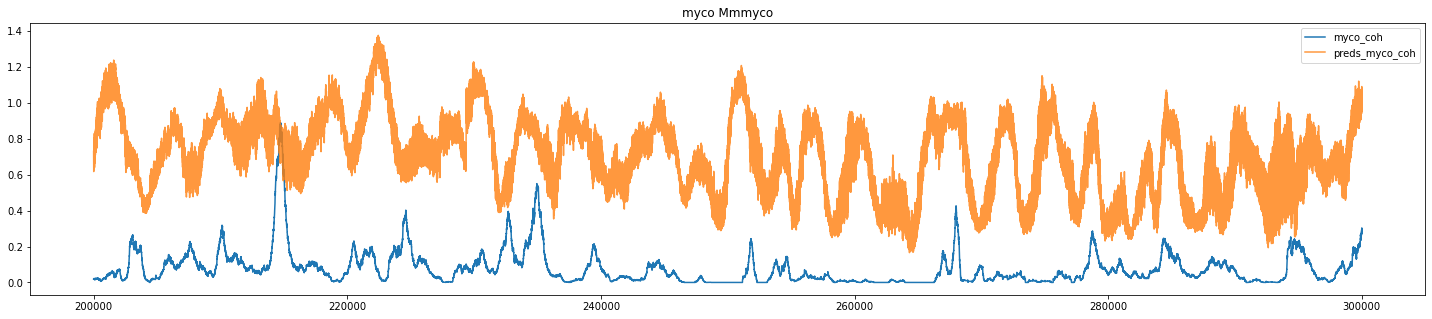

In [82]:
strand = 'myco' # 'pneu' #
chr_id = 'Mmmyco'
start = 200_000
stop = start + 100_000

fig, ax = plt.subplots(1, 1, figsize=(25, 5), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])

plt.title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), myco_coh[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), myco_coh_KL[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_coh', alpha=0.8)

# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')
# ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_pol', alpha=0.8)
plt.legend()
print(pearsonr(myco_coh_KL[chr_id][start:stop], preds_m[chr_id][start:stop]))

(0.7553135383872812, 0.0)


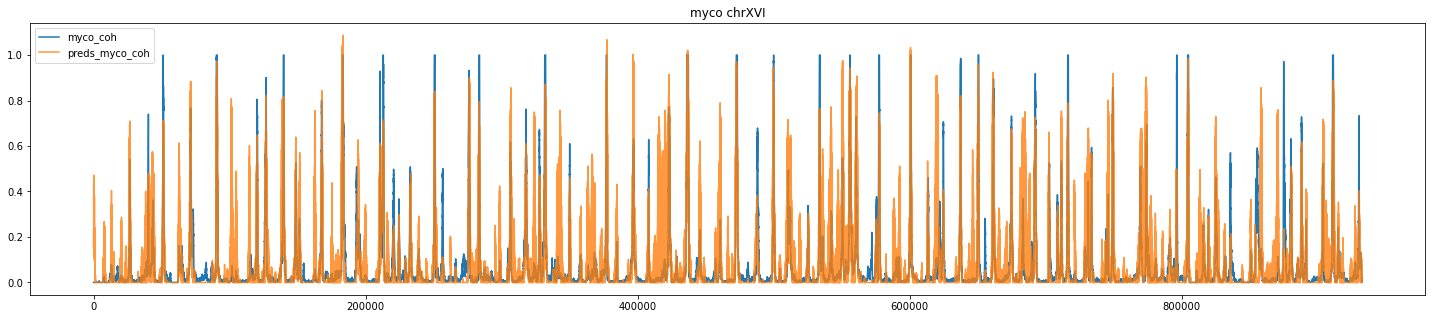

In [80]:
strand = 'myco' # 'pneu' #
chr_id = 'XVI'
start = 000_000
stop = start + 1_000_000

fig, ax = plt.subplots(1, 1, figsize=(25, 5), facecolor='w')
if strand == 'myco' and chr_id != 'Mmmyco':
    chr_id = 'chr' + chr_id
stop = min(stop, lens[strand][chr_id])

plt.title(f'{strand} {chr_id}')
# ax.plot(np.arange(start, stop), myco_coh[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), myco_coh_KL[chr_id][start:stop], label='myco_coh')
ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_coh', alpha=0.8)

# ax.plot(np.arange(start, stop), myco_pol[chr_id][start:stop], label='myco_pol')
# ax.plot(np.arange(start, stop), myco_pol_KL[chr_id][start:stop], label='myco_pol_KL')
# ax.plot(np.arange(start, stop), preds_m[chr_id][start:stop], label='preds_myco_pol', alpha=0.8)
plt.legend()
print(pearsonr(myco_coh_KL[chr_id][start:stop], preds_m[chr_id][start:stop]))

In [26]:
model_name = 'model_pneu_pol_3'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs_KL = df1.join(df2, lsuffix='_KL')
df_corrs_KL

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.778118,0.717623,0.814402,0.779190,0.714632,0.660440,0.711586,0.688914
chrII,0.606008,0.624445,0.673078,0.695824,0.576533,0.591645,0.614507,0.635473
chrIII,0.730906,0.755172,0.677016,0.564481,0.666838,0.687603,0.624686,0.531420
chrIV,0.673096,0.655601,0.607170,0.608528,0.622579,0.608644,0.552900,0.555872
chrV,0.486120,0.496397,0.512657,0.549151,0.458975,0.467682,0.507079,0.529022
chrVI,0.473498,0.403228,0.438366,0.523341,0.467383,0.415898,0.438253,0.502965
chrVII,0.665991,0.657687,0.595867,0.590182,0.617489,0.613158,0.551839,0.545571
chrVIII,0.557506,0.574818,0.609527,0.600329,0.491971,0.514691,0.556232,0.549221
chrIX,0.654495,0.646553,0.557174,0.518024,0.603160,0.596602,0.496686,0.474298
chrX,0.651669,0.634396,0.567763,0.549890,0.616021,0.603193,0.525457,0.511500


In [29]:
model_name = 'model_myco_pol_7'
df1 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs_KL'), index_col=0)
df2 = pd.read_csv(Path(data_dir, 'SCerevisiae', 'results', model_name, f'chromosome_corrs'), index_col=0)
df_corrs = df1.join(df2, lsuffix='_KL')
df_corrs

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.797443,0.806631,0.751074,0.768292,0.769238,0.782158,0.669672,0.692196
chrII,0.727367,0.711531,0.613350,0.601384,0.729068,0.712899,0.593685,0.587569
chrIII,0.682555,0.665136,0.545165,0.485107,0.676286,0.644371,0.518189,0.467320
chrIV,0.769490,0.772469,0.570046,0.590372,0.748767,0.749799,0.544276,0.562511
chrV,0.679366,0.672826,0.441846,0.472636,0.668428,0.664125,0.455143,0.486982
chrVI,0.506890,0.595065,0.381788,0.602991,0.547031,0.619664,0.410265,0.577339
chrVII,0.761443,0.724904,0.562735,0.528900,0.748872,0.718587,0.543299,0.513331
chrVIII,0.691136,0.683409,0.555076,0.569974,0.664787,0.663558,0.533264,0.551586
chrIX,0.772817,0.800431,0.538184,0.477078,0.752918,0.768976,0.505794,0.462701
chrX,0.699149,0.709835,0.528640,0.511840,0.697947,0.702000,0.509298,0.492668


In [28]:
df_corrs_KL - df_corrs

,W303_Mmmyco_KL,W303_Mmmyco_rev_KL,S288c_Mpneumo_KL,S288c_Mpneumo_rev_KL,W303_Mmmyco,W303_Mmmyco_rev,S288c_Mpneumo,S288c_Mpneumo_rev
chrI,0.036851,0.030550,0.036864,0.067493,-0.006690,-0.013631,-0.004688,0.020415
chrII,-0.036636,-0.019202,-0.010498,0.029997,-0.075973,-0.055788,-0.052335,-0.015804
chrIII,0.091515,0.092354,0.014298,-0.022422,0.026199,0.030311,-0.022283,-0.051888
chrIV,-0.001864,-0.011170,-0.019821,-0.025302,-0.042925,-0.051884,-0.057399,-0.061923
chrV,-0.022854,-0.008929,-0.023576,-0.015250,-0.052936,-0.041190,-0.048024,-0.054718
chrVI,0.025858,0.049044,-0.010524,0.035453,-0.010092,0.008431,-0.048667,-0.008514
chrVII,-0.001628,-0.011831,-0.022907,-0.017815,-0.042481,-0.047988,-0.052602,-0.050931
chrVIII,-0.015751,-0.011334,-0.013601,-0.046257,-0.055984,-0.048927,-0.050663,-0.082456
chrIX,0.007854,0.013155,-0.008775,-0.014439,-0.027538,-0.007447,-0.053314,-0.035758
chrX,0.025944,0.043639,0.000921,-0.006285,-0.018170,0.002800,-0.038449,-0.042462


In [40]:
for chr_id, labels in myco_pol_KL.items():
    print(chr_id, pearsonr(all_preds[chr_id], labels))

chrI (0.7335456275616082, 0.0)
chrII (0.5883894441610705, 0.0)
chrIII (0.5172738349970311, 0.0)
chrIV (0.5883103469219824, 0.0)
chrV (0.22914877804416117, 0.0)
chrVI (0.26034938414976533, 0.0)
chrVII (0.5925840786070067, 0.0)
chrVIII (0.3677832212251349, 0.0)
chrIX (0.6918413992820829, 0.0)
chrX (0.47085433139240773, 0.0)
chrXI (0.5417987545875256, 0.0)
chrXII (0.47293105669054714, 0.0)
chrXIII (0.5162041741161434, 0.0)
chrXIV (0.4700374196088256, 0.0)
chrXV (0.4732089093045596, 0.0)
chrXVI (0.4415549472611823, 0.0)
Mmmyco (-0.07041125615214144, 0.0)


In [4]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    # My preferred way to deal with inf
    x_[np.isinf(x_)] = np.max(x_[np.isfinite(x_)])
    # Workaround Etienne's way to avoid inf in cohesine myco
    # x_[np.isinf(x_)] = np.percentile(x_, 98)
    # Etienne's way
    # x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    # x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

def load_yeast_bw(filename, bact='myco', romantoint=False, process=None):
    # Load bigwig
    labels = utils.load_bw(filename)
    # Change chromosome names
    if romantoint:
        for key in list(labels.keys()):
            if key[:3] == 'chr':
                new_key = 'chr' + format(utils.roman_to_int(key[3:]), '02d')
                labels[new_key] = labels.pop(key)
    if bact == 'myco':
        chr_id = list({'Mmm_Linear_740kb.fa', 'Mmmyco'}.intersection(labels.keys()))
        assert len(chr_id) == 1
        labels['myco'] = labels.pop(chr_id[0])
    elif bact == 'pneu':
        labels['pneu'] = labels.pop('Pneu300')
    # Remove unwanted chromosomes
    for key in list(labels.keys()):
        if key[:3] != 'chr' and key != bact:
            labels.pop(key)
    # Transform data
    if process is not None:
        if process == 'conv':
            process = lambda x: utils.moving_average(x, 21, keepsize=True)
        elif process == 'log':
            process = lambda x: np.log2(1 + x)
        for key, value in labels.items():
            labels[key] = process(value)
    # Normalize in CPM
    thres = sum(v.sum() for v in labels.values()) / 1e6
    for key, value in labels.items():
        labels[key] = value / thres
    return labels

def load_yeast_nuc(mycofile=None, pneufile=None, asdict=True, priority='myco', process='conv'):
    if mycofile is None:
        mycofile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM_myco265.bw'
    if pneufile is None:
        pneufile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM_pneumo205.bw'
    # Load bigwigs
    labels_myco = load_yeast_bw(mycofile, bact='myco', process=process)
    labels_pneu = load_yeast_bw(pneufile, bact='pneu', process=process)
    # Get labels from priority file
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value
        labels['pneu'] = labels_pneu['pneu']
    else:
        for key, value in labels_pneu.items():
            labels[key] = value
        labels['myco'] = labels_myco['myco']
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                    asdict=True, priority='myco'):
    # Get log ratios
    labels_myco = {}
    for key, value in labels_ipmyco.items():
        labels_myco[key] = log(value / labels_ctrlmyco[key])
    thres_myco = sum(v.sum() for v in labels_myco.values()) / 1e6
    labels_pneu = {}
    for key, value in labels_ippneu.items():
        labels_pneu[key] = log(value / labels_ctrlpneu[key])
    thres_pneu = sum(v.sum() for v in labels_pneu.values()) / 1e6
    # Get labels from priority file, and normalize in CPM
    labels = {}
    if priority == 'myco':
        for key, value in labels_myco.items():
            labels[key] = value / thres_myco
        labels['pneu'] = labels_pneu['pneu'] / thres_pneu
    else:
        for key, value in labels_pneu.items():
            labels[key] = value / thres_pneu
        labels['myco'] = labels_myco['myco'] / thres_myco
    # Return dictionary by chromosome, or an array per genome
    if asdict:
        return labels
    else:
        return (
            np.concatenate([v for k, v in labels.items() if k[:3] == 'chr']),
            labels['myco'],
            labels['pneu']
        )

def load_yeast_coh(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='pneu'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703630_Scc1_Mmyco_rep1.CPM.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/GSM6703631_Scc1-inp_Mmyco_rep1.CPM.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM219.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM220.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco', romantoint=True)
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco', romantoint=True)
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

def load_yeast_pol(mycoipfile=None, mycoctrlfile=None, pneuipfile=None, pneuctrlfile=None,
                   asdict=True, priority='myco'):
    if mycoipfile is None:
        mycoipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM102.bw'
    if mycoctrlfile is None:
        mycoctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/myco/coverage_RPKM105.bw'
    if pneuipfile is None:
        pneuipfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM154.bw'
    if pneuctrlfile is None:
        pneuctrlfile = '/home/alex/shared_folder/SCerevisiae/data/Data_etienne/Bacterial_genome_project/data/for_Julien/pneumo/coverage_RPKM155.bw'
    # Load bigwigs
    labels_ipmyco = load_yeast_bw(mycoipfile, bact='myco')
    labels_ctrlmyco = load_yeast_bw(mycoctrlfile, bact='myco')
    labels_ippneu = load_yeast_bw(pneuipfile, bact='pneu')
    labels_ctrlpneu = load_yeast_bw(pneuctrlfile, bact='pneu')
    return load_yeast_chip(labels_ipmyco, labels_ctrlmyco, labels_ippneu, labels_ctrlpneu,
                           asdict=asdict, priority=priority)

# labels_nuc_yeast, labels_nuc_myco, labels_nuc_pneu = load_yeast_nuc(asdict=False, process=None)
# labels_coh_yeast, labels_coh_myco, labels_coh_pneu = load_yeast_coh(asdict=False)
# labels_pol_yeast, labels_pol_myco, labels_pol_pneu = load_yeast_pol(asdict=False)
labels_nuc = load_yeast_nuc()
labels_coh = load_yeast_coh()
labels_pol = load_yeast_pol()

/tmp/ipykernel_1583890/180740096.py:80: RuntimeWarning: divide by zero encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1583890/180740096.py:80: RuntimeWarning: invalid value encountered in true_divide
  labels_myco[key] = log(value / labels_ctrlmyco[key])
/tmp/ipykernel_1583890/180740096.py:84: RuntimeWarning: divide by zero encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])
/tmp/ipykernel_1583890/180740096.py:84: RuntimeWarning: invalid value encountered in true_divide
  labels_pneu[key] = log(value / labels_ctrlpneu[key])


In [5]:
species = 'SCerevisiae'

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_W303.npz')) as f:
    preds_nuc = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_on_Pneu300.npz')) as f:
    preds_nuc['pneu'] = f['chr1']
thres_pred_nm = sum([np.sum(v) for k, v in preds_nuc.items() if k!='pneu']) / 1e6
print(thres_pred_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_W303.npz')) as f:
    preds_nuc2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep2_on_Pneu300.npz')) as f:
    preds_nuc2['pneu'] = f['chr1']
thres_pred2_nm = sum([np.sum(v) for k, v in preds_nuc2.items() if k!='pneu']) / 1e6
print(thres_pred2_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_W303.npz')) as f:
    preds_nuc3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Mmm_Linear_740kb.npz')) as f:
    preds_nuc3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_nucleosome_myco_rep3_on_Pneu300.npz')) as f:
    preds_nuc3['pneu'] = f['chr1']
thres_pred3_nm = sum([np.sum(v) for k, v in preds_nuc3.items() if k!='pneu']) / 1e6
print(thres_pred3_nm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_W303_with_last.npz')) as f:
    preds_coh = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_on_Pneu300_with_last.npz')) as f:
    preds_coh['pneu'] = f['chr1']
thres_pred_cm = sum([np.sum(v) for k, v in preds_coh.items() if k!='pneu']) / 1e6
print(thres_pred_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_W303_with_last.npz')) as f:
    preds_coh2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_2_on_Pneu300_with_last.npz')) as f:
    preds_coh2['pneu'] = f['chr1']
thres_pred2_cm = sum([np.sum(v) for k, v in preds_coh2.items() if k!='pneu']) / 1e6
print(thres_pred2_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_W303_with_last.npz')) as f:
    preds_coh3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_coh3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_rep1_cohesine_3_on_Pneu300_with_last.npz')) as f:
    preds_coh3['pneu'] = f['chr1']
thres_pred3_cm = sum([np.sum(v) for k, v in preds_coh3.items() if k!='pneu']) / 1e6
print(thres_pred3_cm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_W303_with_last.npz')) as f:
    preds_pol = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_on_Pneu300_with_last.npz')) as f:
    preds_pol['pneu'] = f['chr1']
thres_pred_pm = sum([np.sum(v) for k, v in preds_pol.items() if k!='pneu']) / 1e6
print(thres_pred_pm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_W303_with_last.npz')) as f:
    preds_pol2 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol2['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_2_on_Pneu300_with_last.npz')) as f:
    preds_pol2['pneu'] = f['chr1']
thres_pred2_pm = sum([np.sum(v) for k, v in preds_pol2.items() if k!='pneu']) / 1e6
print(thres_pred2_pm)

with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_W303_with_last.npz')) as f:
    preds_pol3 = {key: f[key] for key in f.keys() if key[:3] == 'chr'}
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Mmm_Linear_740kb_with_last.npz')) as f:
    preds_pol3['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', 'preds_weights_myco_pol2_2048_16_3_on_Pneu300_with_last.npz')) as f:
    preds_pol3['pneu'] = f['chr1']
thres_pred3_pm = sum([np.sum(v) for k, v in preds_pol3.items() if k!='pneu']) / 1e6
print(thres_pred3_pm)

2.4397877109375
2.3684437265625
2.4556031328125
15.128140497459292
13.782405389259338
14.714640640129089
7.697727021959037
9.267423528263093
9.620498055236816


In [6]:
with np.load('../shared_folder/SCerevisiae/genome/W303/W303.npz') as f:
    one_hots_yeast = {key: f[key] for key in f.keys() if key[:3]=='chr'}
with np.load('../shared_folder/SCerevisiae/genome/bacterie/Mmm_Linear_740kb.npz') as f:
    one_hot_myco = f['chr1']
with np.load('../shared_folder/SCerevisiae/genome/bacterie/Pneu300.npz') as f:
    one_hot_pneu = f['chr1']

In [7]:
model_name = 'weights_myco_rep1_cohesine' # 'weights_myco_pol2_2048_16_3'
preds = {}
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_W303_full.npz')) as f:
    for chr_id in f.keys():
        if chr_id[:3] == 'chr':
            preds[chr_id] = f[chr_id]
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_Mmm_Linear_740kb_full.npz')) as f:
    preds['myco'] = f['chr1']
with np.load(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_name}_on_Pneu300_full.npz')) as f:
    preds['pneu'] = f['chr1']

In [316]:
chr_id = 'chr14'
np.corrcoef([labels_pol[chr_id], preds_pol[chr_id], preds_pol2[chr_id], preds_pol3[chr_id], (preds_pol[chr_id] + preds_pol2[chr_id] + preds_pol3[chr_id]) / 3])[:, 0]

array([1.        , 0.64051676, 0.70745244, 0.7050577 , 0.71947583])

In [302]:
WINDOW = 2048
head_interval = 128
n_heads = WINDOW // 128
temps = {}
for chr_id, pred in preds.items():
    temp_len = ((len(pred) - WINDOW - head_interval + 1) // WINDOW + 1) * head_interval * n_heads
    temp = np.transpose(pred[:temp_len].reshape(-1, n_heads, 128), [0, 2, 1])
    temps[chr_id] = temp

In [303]:
chr_id = 'pneu'
temp_len = temps[chr_id].size
trunc_pred = preds[chr_id].copy()
trunc_pred[temp_len:] = 0

trunc_preds_pol = preds_pol3[chr_id].copy()
trunc_preds_pol[temp_len:] = 0
np.corrcoef([labels_pol[chr_id], preds_pol3[chr_id], trunc_preds_pol, preds[chr_id], trunc_pred])[:, 0]

array([1.        , 0.18516879, 0.18516879, 0.1925391 , 0.19151585])

In [304]:
np.corrcoef([labels_pol[chr_id][:temp_len], preds_pol3[chr_id][:temp_len], trunc_preds_pol[:temp_len], preds[chr_id][:temp_len], trunc_pred[:temp_len]])[:, 0]

array([1.        , 0.18616049, 0.18616049, 0.19250753, 0.19250753])

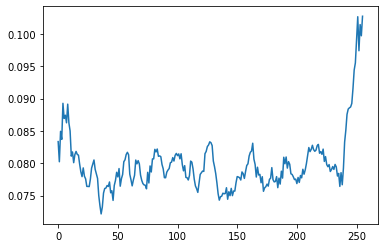

In [237]:
plt.plot(np.mean([np.mean(np.std(temp, axis=1), axis=0) for temp in temps.values()], axis=0))

In [238]:
np.mean([np.mean(np.std(temp, axis=1)) for temp in temps.values()], axis=0), np.mean([np.mean(np.std(temp, axis=2)) for temp in temps.values()], axis=0)

(0.07993876293018973, 0.5890472379804587)

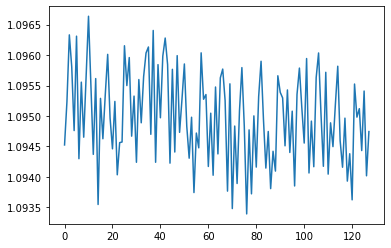

In [245]:
plt.plot(np.mean([np.mean(temp, axis=(0, 2)) for temp in temps.values()], axis=0))

[1.0,
 -0.05998617836891999,
 0.25514203680751935,
 -0.16821651189833972,
 0.03784069122450806,
 -0.19171474021887397,
 0.21699868559762836,
 -0.05885050856678878,
 0.8005205735141387,
 -0.11153211910064262]

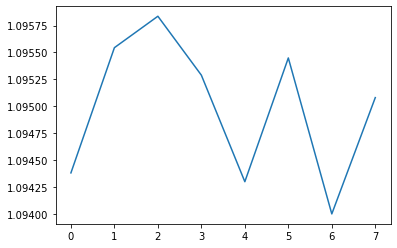

In [250]:
plt.plot(np.mean([np.mean(temp, axis=(0, 2)) for temp in temps.values()], axis=0).reshape(-1, 8).mean(axis=0))

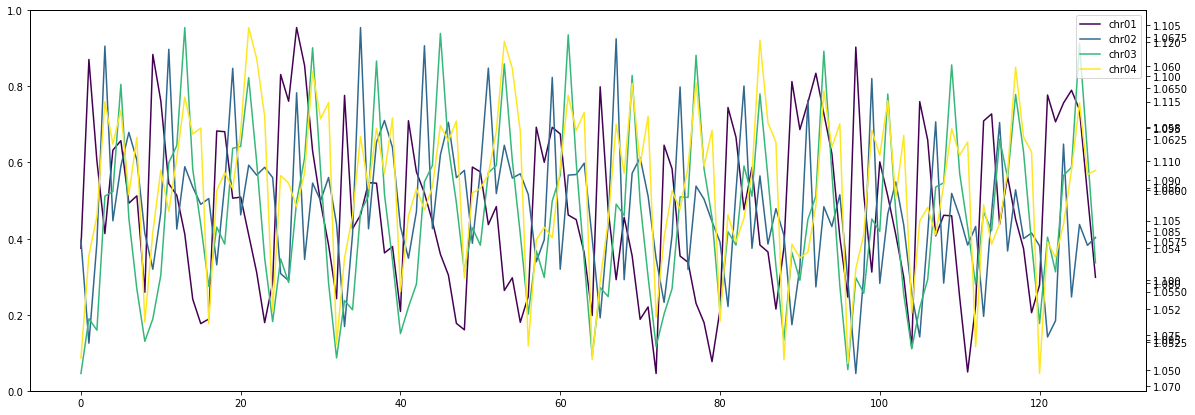

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
axes = [ax]
chrs = list(temps.keys())[:4] #['chr01', 'chr16', 'myco', 'pneu']
for i, chr_id in enumerate(chrs):
    axes.append(ax.twinx())
    axes[-1].plot(np.mean(temps[chr_id], axis=(0, 2)), label=chr_id, color=mpl.colormaps['viridis'](i / (len(chrs) - 1)))
h, l = plot_utils.add_legend(axes)
plt.legend(h, l)

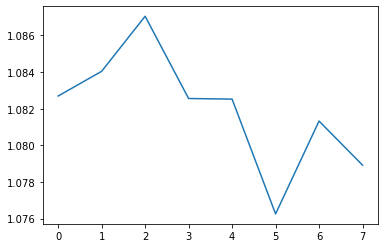

In [229]:
plt.plot(np.mean(temps[chr_id], axis=(0, 2)).reshape(-1, 8).mean(axis=0))

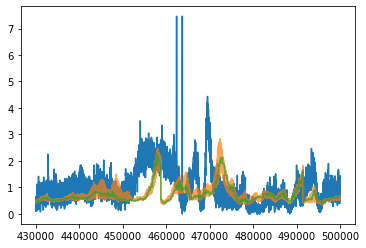

In [25]:
chr_id = 'pneu'
plot_start = 430_000
plot_stop = plot_start + 70_000
plt.plot(np.arange(plot_start, plot_stop), labels_coh[chr_id][plot_start:plot_stop] * thres_pred_cm)
plt.plot(np.arange(plot_start, plot_stop), preds[chr_id][plot_start:plot_stop], alpha=0.7)
plt.plot(np.arange(plot_start, plot_stop), preds_coh[chr_id][plot_start:plot_stop], alpha=0.7)

In [15]:
np.corrcoef([labels_coh[chr_id], preds[chr_id], preds_coh[chr_id]])[:, 0]

array([1.        , 0.42431742, 0.42832975])

In [26]:
np.corrcoef([labels_coh[chr_id][plot_start:plot_stop], preds[chr_id][plot_start:plot_stop], preds_coh[chr_id][plot_start:plot_stop]])[:, 0]

array([1.        , 0.18807992, 0.18046995])

In [12]:
np.corrcoef([labels_coh[chr_id][plot_start:plot_stop], preds[chr_id][plot_start:plot_stop], preds_coh[chr_id][plot_start:plot_stop]])[:, 0]

array([1.        , 0.64693125, 0.63872126])

In [151]:
species = 'SCerevisiae'
genomes = ['W303', 'Mmm_Linear_740kb', 'Pneu300']
model_files = [
    # (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep2.hdf5'), 'nucleosome'),
    # (Path(data_dir, species, 'models_etienne', 'weights_nucleosome_myco_rep3.hdf5'), 'nucleosome'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_2.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_rep1_cohesine_3.hdf5'), 'cohesine'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16.hdf5'), 'pol'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_2.hdf5'), 'pol'),
    (Path(data_dir, species, 'models_etienne', 'weights_myco_pol2_2048_16_3.hdf5'), 'pol'),
    ]
for model_file, annotation_type in model_files:
    for genome in genomes:
        if annotation_type == 'nucleosome':
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate, 'mae_cor' : mae_cor})
            order_suffix = '_ATCG'
        else:
            model = tf.keras.models.load_model(model_file, custom_objects={'correlate' : correlate})
            order_suffix = ''
        if genome == 'W303':
            genome_dir = 'W303'
        else:
            genome_dir = 'bacterie'
        all_preds = {}
        with np.load(Path(data_dir, species, 'genome', genome_dir, f'{genome}{order_suffix}.npz')) as f:
            for chr_id in f.keys():
                one_hot_chr = f[chr_id]
                try:
                    all_preds[chr_id] = full_predict(one_hot_chr, model, annotation_type, last_window=True)
                except ValueError:
                    print(f"Can't predict on {chr_id}, skipping...")
        del model
        np.savez(Path(data_dir, species, 'results', 'models_etienne', f'preds_{model_file.stem}_on_{genome}_full.npz'), **all_preds)

Can't predict on p2, skipping...
Can't predict on p2, skipping...
Can't predict on p2, skipping...
